In [1]:
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
plt.style.use('dark_background')

## Paleoclimate models

This notebook processes model output from the paleoclimate portion of CMIP-6. For the purposes of this exercise, we will use results from the MRI-ESM2.0 model run. The recommended input files are:

1. **Surface temperature:** ts_Amon_MRI-ESM2-0_past1000_r1i1p1f1_gn_085001-184912
1. **Soil moisture content:** mrso_Lmon_MRI-ESM2-0_past1000_r1i1p1f1_gn_085001-184912
2. **Snow depth:** snd_LImon_MRI-ESM2-0_past1000_r1i1p1f1_gn_085001-184912

From these datasets, we will also be able to estimate volumetric soil water content and temperature variability.

More information on the paleoclimate modeling intercomparison project can be found here: https://pmip.lsce.ipsl.fr/.

More information on MRI-ESM2.0 can be found here: https://www.jstage.jst.go.jp/article/jmsj/advpub/0/advpub_2019-051/_article/-char/en.

### Initial processing

In [2]:
# Load the datasets from input files
ts_nc = Dataset('/data/ts_Amon_MRI-ESM2-0_past1000_r1i1p1f1_gn_085001-184912.nc')
mrso_nc = Dataset('/data/mrso_Lmon_MRI-ESM2-0_past1000_r1i1p1f1_gn_085001-184912.nc')
snd_nc = Dataset('/data/snd_LImon_MRI-ESM2-0_past1000_r1i1p1f1_gn_085001-184912.nc')

If you are interested in taking this model to a different site than Eight Mile Lake, change the lat-lon values in the following code cell.

In [3]:
# Find the array indices for latitude and longitude

# If you have a different site in mind, change these values
eml_lat = 63.8
eml_lon = -149.25

# Identify array indices from the netCDF metadata
ts_lat = np.argmin(np.abs(ts_nc.variables['lat'][:] - eml_lat))
ts_lon = np.argmin(np.abs(ts_nc.variables['lon'][:] - (360 + eml_lon)))

mrso_lat = np.argmin(np.abs(mrso_nc.variables['lat'][:] - eml_lat))
mrso_lon = np.argmin(np.abs(mrso_nc.variables['lon'][:] - (360 + eml_lon)))

snd_lat = np.argmin(np.abs(snd_nc.variables['lat'][:] - eml_lat))
snd_lon = np.argmin(np.abs(snd_nc.variables['lon'][:] - (360 + eml_lon)))

In [4]:
# Using the lat and lon indices, get the monthly time series for each variable
ts = ts_nc.variables['ts'][:,ts_lat,ts_lon]
mrso = mrso_nc.variables['mrso'][:,mrso_lat,mrso_lon]
snd = snd_nc.variables['snd'][:,snd_lat,snd_lon]

In [5]:
# Ku likes surface temperature in degrees Celsius
ts += -273.15

In [6]:
# Use numpy tricks to get the annual mean of each time series
ts_mean = np.mean(ts.reshape(-1, 12), axis = 1)
mrso_mean = np.mean(mrso.reshape(-1, 12), axis = 1)
snd_mean = np.mean(snd.reshape(-1, 12), axis = 1)

In [7]:
# Estimate the amplitude of monthly surface temperature
ts_amp = 0.5 * (np.max(ts.reshape(-1, 12), axis = 1) - np.min(ts.reshape(-1, 12), axis = 1))

In [8]:
# Estimate soil volumetric water content
vwc_mean = np.divide(mrso_mean, 1200)

All of these time series can be altered with standard array operations. For example, to run the model for a warmer climate, change the surface temperatures:

In [9]:
# Add 2 degrees of warming to the entire time series
ts_warm = ts_mean + 2

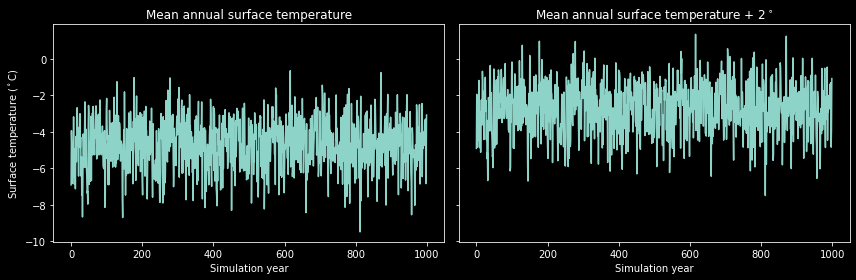

In [10]:
# Plot the results!
fig, ax = plt.subplots(1, 2, figsize = (12, 4), sharey = True)

ax[0].plot(ts_mean)
ax[1].plot(ts_warm)

ax[0].set_ylabel('Surface temperature ($^\circ$C)')
ax[0].set_xlabel('Simulation year')
ax[1].set_xlabel('Simulation year')

ax[0].set_title('Mean annual surface temperature')
ax[1].set_title('Mean annual surface temperature + 2$^\circ$')

plt.tight_layout()
plt.show()

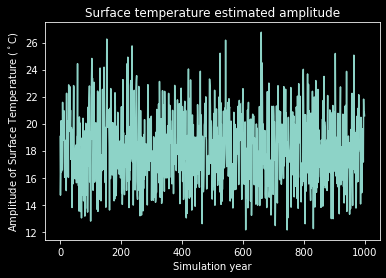

In [11]:
# Plot temperature variability
plt.plot(ts_amp)
plt.xlabel('Simulation year')
plt.ylabel('Amplitude of Surface Temperature ($^\circ$C)')
plt.title('Surface temperature estimated amplitude')
plt.show()

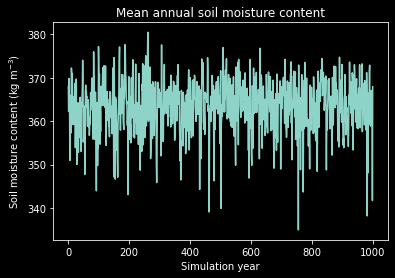

In [12]:
# Plot soil moisture
plt.plot(mrso_mean)
plt.xlabel('Simulation year')
plt.ylabel('Soil moisture content (kg m$^{-3}$)')
plt.title('Mean annual soil moisture content')
plt.show()

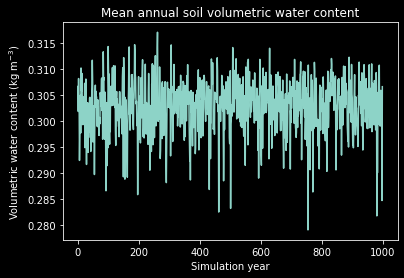

In [13]:
# Plot volumetric water content
plt.plot(vwc_mean)
plt.xlabel('Simulation year')
plt.ylabel('Volumetric water content (kg m$^{-3}$)')
plt.title('Mean annual soil volumetric water content')
plt.show()

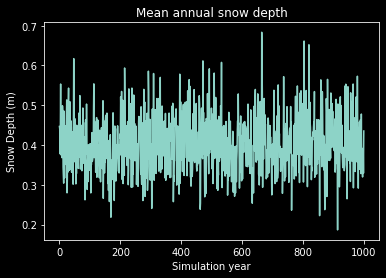

In [14]:
# Plot snow depth
plt.plot(snd_mean)
plt.xlabel('Simulation year')
plt.ylabel('Snow Depth (m)')
plt.title('Mean annual snow depth')
plt.show()

### Final step: save the results

We'll use text files as inputs for Ku. The trick here is to give the files the same name as whatever you use in the configuration (.cfg) file for your Ku model run. If you want to do two different Ku runs and compare the results (e.g., for different surface temperature inputs), use two different configuration files.

Before running the following code cell, make a folder called 'inputs/' or something similar to store the files.

In [15]:
np.savetxt('./inputs/T_air.txt', ts_mean)
np.savetxt('./inputs/h_snow.txt', snd_mean)
np.savetxt('./inputs/mrso.txt', mrso_mean)
np.savetxt('./inputs/vwc.txt', vwc_mean)
np.savetxt('./inputs/A_air.txt', ts_amp)

# These are additional input files for Ku
# As with the above examples, these can be modified for each model run
# NOTE: Each input file needs to be the same length

dfvg = np.full_like(ts_mean, 1e-6) # Thermal diffusivity of frozen vegetation (m^2 s^-1)
dtvg = np.full_like(ts_mean, 1e-6) # Thermal diffusivity of thawed vegetation (m^2 s^-1)

# Note that this example run has no vegetation, so the thermal diffusivities above are irrelevant
hfvg = np.full_like(ts_mean, 0) # Height of frozen vegetation (m)
htvg = np.full_like(ts_mean, 0) # Height of thawed vegetation (m)

rho_snow = np.full_like(ts_mean, 240) # Snow density (kg m^-3)

np.savetxt('./inputs/dfvg.txt', dfvg)
np.savetxt('./inputs/dtvg.txt', dtvg)
np.savetxt('./inputs/hfvg.txt', hfvg)
np.savetxt('./inputs/htvg.txt', htvg)
np.savetxt('./inputs/rho_snow.txt', rho_snow)